# Modeling and hyperparamter tuning - Prodigy Eudcation review classifier

## Contents

    1. Introduction
    2. Imports
    3. Splitting the data into training and testing
    4. Modeling and Hyperparamter Tuning
        4.1 Default Logistic Regression (Unbalanced)
        4.2 Scoring function for Hyperparamter tuning
        4.3 Logistic Regression - Hyperparameter Tuning
        4.4 Multinomial Naive Bayes classfier - Hyperparameter Tuning
        4.5 Random Forest - Hyperparamter tuning
        4.6 XGBoost - Hyperparamter Tuning
        4.7 Keras model
        4.8 Model selection
    5. Business Impact
    6. Summary
    7. Future Work

## 1. Introduction

In this notebook, the review content and labels are split into training and testing sets and a variety of machine learning models will be fit to see which model can be used to predict the type of issue based on the user's review content. The data is already preprocessed in a formt suitable for analysis from the previous notebook.

## 2. Imports

In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure


from sklearn.model_selection import train_test_split # to split into training and testing sets
from sklearn.metrics import classification_report, matthews_corrcoef,plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer # to convert words into features
from sklearn.model_selection import RandomizedSearchCV #hyperparamter search
from sklearn.linear_model import LogisticRegression #classification model
from sklearn.naive_bayes import MultinomialNB #classification model
from sklearn.ensemble import RandomForestClassifier #classification model
from xgboost import XGBClassifier #classification model
from sklearn.metrics import make_scorer #to make custom scoring function

### The preprocessed data from previous notebook is saved as  csv to be used here.

In [2]:
data=pd.read_csv("preprocessed_dataframe.csv")

In [3]:
data.head()

,reason,lemmatized_content
0,No specific reason,terrible
1,Gameplay,this is a horrible app you have to have a memb...
2,Gameplay,this game is hella pay to win everything revol...
3,Technical,horible this gam is bad on phone and wont let ...
4,Membership,it used to be a good game until they added mem...


## 3. Splitting the data into training and testing

In [4]:
#Defining the X and y variables
X=data.lemmatized_content.astype('str')
y=data.reason

In [5]:
#Splitting into training and testing datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)
print(X_train.shape,X_test.shape)

(408,) (102,)


In [6]:
vectorizertr = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             binary=False , token_pattern=r'\w+' , sublinear_tf=False)
tfidf_tr=vectorizertr.fit_transform(X_train)

In [7]:
tfidf_ts=vectorizertr.transform(X_test)

## 4. Modeling and Hyperparamter Tuning

## 4.1 Default Logistic Regression (Unbalanced)

In [8]:
clf=LogisticRegression()
clf.fit(tfidf_tr,y_train)

LogisticRegression()

In [9]:
y_pred=clf.predict(tfidf_ts)

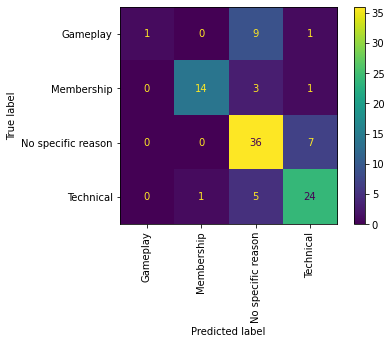

In [10]:
plot_confusion_matrix(clf, tfidf_ts, y_test,xticks_rotation='vertical')#,normalize="true")

In [11]:
## Metric for evaluating models: matthews coorelation 
#https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd
print("Matthews correlation coeff dor test set:",matthews_corrcoef(y_test,y_pred))

Matthews correlation coeff dor test set: 0.6093073296485769


## 4.2 Scoring function for Hyperparamter tuning

### The Matthews correltion coefficient is used as a scoring metric because it taes into account the true positives, true negatives, false positives and false negatives.

In [12]:
#scoring function for all models
mcc_scorer=make_scorer(matthews_corrcoef)

## 4.3 Logistic Regression - Hyperparameter Tuning

In [13]:
w = ["balanced",None ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w,
                   "C": crange,
                   "fit_intercept": [True, False],
                  "multi_class":["auto","ovr","multinomial"]}

In [14]:
# Create a randomized search object and fit 
log_rand_search = RandomizedSearchCV(LogisticRegression(),hyperparam_grid,scoring=mcc_scorer,n_iter=1000, cv=10, n_jobs=-1)
log_rand_search.fit(tfidf_tr,y_train)
print(f'Best score: {log_rand_search.best_score_} with param: {log_rand_search.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 468 is smaller than n_iter=1000. Running 468 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score: 0.6224776589246579 with param: {'multi_class': 'ovr', 'fit_intercept': True, 'class_weight': 'balanced', 'C': 1.0}


In [15]:
#Calculate the Matthew corr score for test set
y_pred=log_rand_search.predict(tfidf_ts)
log_test_score=round(matthews_corrcoef(y_test,y_pred),3)
print("Matthews correlation coefficient for test set:",log_test_score)

Matthews correlation coefficient for test set: 0.67


In [16]:
coefficients_logistic=pd.DataFrame({"feature":vectorizertr.get_feature_names(),"coefficient":log_rand_search.best_estimator_.coef_[0]})
coefficients_logistic.sort_values(by="coefficient")

,feature,coefficient
792,suck,-1.139891
56,bad,-0.941740
524,membership,-0.910258
337,google,-0.847696
501,love,-0.832547
...,...,...
861,type,1.568627
680,remember,1.577908
495,look,1.690613
922,wizard,1.700477


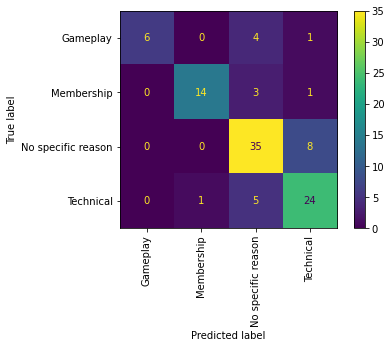

In [17]:
plot_confusion_matrix(log_rand_search, tfidf_ts, y_test,xticks_rotation='vertical')#,normalize="true")

## 4.4 Multinomial Naive Bayes classfier - Hyperparameter Tuning

In [18]:
hyperparam_grid={"alpha":[0.001,0.005,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                "fit_prior":[True,False]}

In [19]:
# Create a randomized search object and fit 
nb_rand_search = RandomizedSearchCV(MultinomialNB(),hyperparam_grid,scoring=mcc_scorer,n_iter=1000, cv=10, n_jobs=-1)
nb_rand_search.fit(tfidf_tr,y_train)
print(f'Best score: {nb_rand_search.best_score_} with param: {nb_rand_search.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=1000. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score: 0.5840110561171775 with param: {'fit_prior': True, 'alpha': 0.1}


In [20]:
#Calculate the Matthew corr score for test set
y_pred=nb_rand_search.predict(tfidf_ts)
nb_test_score=round(matthews_corrcoef(y_test,y_pred),3)
print("Matthews correlation coefficient for test set:",nb_test_score)

Matthews correlation coefficient for test set: 0.569


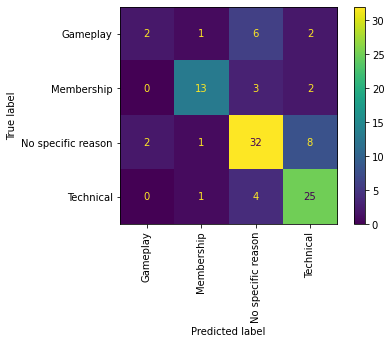

In [21]:
plot_confusion_matrix(nb_rand_search, tfidf_ts, y_test,xticks_rotation='vertical')#,normalize="true")

## 4.5 Random Forest - Hyperparamter tuning

In [22]:
#Defining the hyperparmater space for random forest
w = [None,"balanced"]
hyperparam_grid={"n_estimators":[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
                   "criterion":["gini", "entropy"],
                   "max_depth":[1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
                   "max_features":["auto", "sqrt", "log2"],
                   "class_weight":w,
                   "bootstrap":[True,False]}

In [23]:
# Create a randomized search object and fit 
rand_forest_rand_search = RandomizedSearchCV(RandomForestClassifier(),hyperparam_grid,scoring=mcc_scorer,n_iter=1000, cv=10, n_jobs=-1)
rand_forest_rand_search.fit(tfidf_tr,y_train)
print(f'Best score: {rand_forest_rand_search.best_score_} with param: {rand_forest_rand_search.best_params_}')

Best score: 0.6243885038092809 with param: {'n_estimators': 50, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}


In [24]:
#Calculate the Matthew corr score for test set
y_pred=rand_forest_rand_search.predict(tfidf_ts)
rf_test_score=round(matthews_corrcoef(y_test,y_pred),3)
print("Matthews correlation coefficient for test set:",rf_test_score)

Matthews correlation coefficient for test set: 0.615


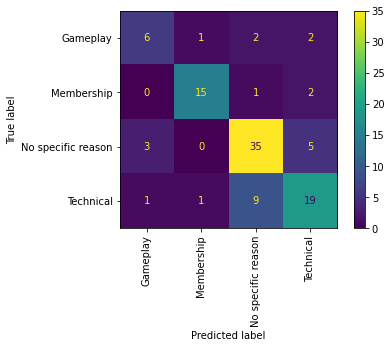

In [25]:
plot_confusion_matrix(rand_forest_rand_search, tfidf_ts, y_test,xticks_rotation='vertical')#,normalize="true")

## 4.6 XGBoost - Hyperparamter Tuning

In [26]:
# A parameter grid for XGBoost
w = [None,"balanced"]
hyperparam_grid = {"n_estimators":[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.25, 0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'class_weight':w,
          'max_depth': [1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
          'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3]
         }

In [27]:
# Create a randomized search object and fit 
xgb_rand_search = RandomizedSearchCV(XGBClassifier(),hyperparam_grid,scoring=mcc_scorer,n_iter=1000, cv=10, n_jobs=-1)
xgb_rand_search.fit(tfidf_tr,y_train)
print(f'Best score: {xgb_rand_search.best_score_} with param: {xgb_rand_search.best_params_}')

[16:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.6146000681400418 with param: {'subsample': 1.0, 'n_estimators': 7, 'min_child_weight': 1, 'max_depth': 75, 'learning_rate': 0.3, 'gamma': 0.25, 'colsample_bytree': 0.6, 'class_weight': None}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [28]:
#Calculate the Matthew corr score for test set
y_pred=xgb_rand_search.predict(tfidf_ts)
xgb_test_score=round(matthews_corrcoef(y_test,y_pred),3)
print("Matthews correlation coefficient for test set:",xgb_test_score)

Matthews correlation coefficient for test set: 0.519


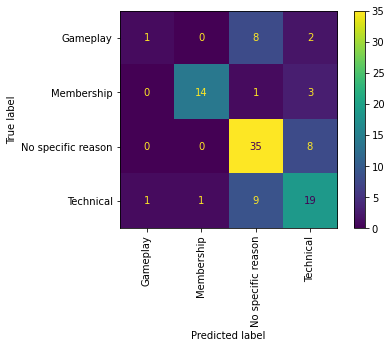

In [29]:
plot_confusion_matrix(xgb_rand_search, tfidf_ts, y_test,xticks_rotation='vertical')#,normalize="true")

## 4.7 Keras model

For the keras model, a bag of words approach is attempted to see the performance

In [30]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder #LabelBinarizer, 
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras import utils as np_utils
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [31]:
from keras import backend as K
def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

In [32]:
#Splitting into training and testing datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)
print(X_train.shape,X_test.shape)

#Converting into tokens
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train

x_train = tokenize.texts_to_matrix(X_train) #convert training dat
x_test = tokenize.texts_to_matrix(X_test) #convert testing data

#Encode categorical output 
encoder = LabelEncoder()
encoder.fit(y)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

#to have 4 output probabilities from the model
num_classes = np.max(y_train) + 1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

#set batch size and epoch
batch_size = 32
epochs = 100

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,))) #input layer
model.add(Activation('relu')) #activation for input layer
model.add(Dropout(0.5)) #set drop out
model.add(Dense(num_classes)) #output layer
model.add(Activation('softmax')) #activation for output layer

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[matthews_correlation_coefficient])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

(408,) (102,)
Epoch 1/100
12/12 [==============================] - 19s 56ms/step - loss: 1.3614 - matthews_correlation_coefficient: 0.0132 - val_loss: 1.2099 - val_matthews_correlation_coefficient: 0.1464
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 1.0831 - matthews_correlation_coefficient: 0.3069 - val_loss: 1.0623 - val_matthews_correlation_coefficient: 0.3019
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.8792 - matthews_correlation_coefficient: 0.4483 - val_loss: 0.9336 - val_matthews_correlation_coefficient: 0.3019
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7270 - matthews_correlation_coefficient: 0.6202 - val_loss: 0.8193 - val_matthews_correlation_coefficient: 0.5808
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6076 - matthews_correlation_coefficient: 0.7443 - val_loss: 0.7171 - val_matthews_correlation_coefficient: 0.7071
Epoch 6/100
12/12 [====================

12/12 [==============================] - 0s 7ms/step - loss: 0.0113 - matthews_correlation_coefficient: 0.9961 - val_loss: 0.5712 - val_matthews_correlation_coefficient: 0.7347
Epoch 45/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0117 - matthews_correlation_coefficient: 0.9973 - val_loss: 0.5665 - val_matthews_correlation_coefficient: 0.7717
Epoch 46/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0113 - matthews_correlation_coefficient: 0.9985 - val_loss: 0.5685 - val_matthews_correlation_coefficient: 0.7717
Epoch 47/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0144 - matthews_correlation_coefficient: 0.9931 - val_loss: 0.5741 - val_matthews_correlation_coefficient: 0.7717
Epoch 48/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0122 - matthews_correlation_coefficient: 0.9916 - val_loss: 0.5798 - val_matthews_correlation_coefficient: 0.7717
Epoch 49/100
12/12 [==============================] - 0s 8ms/st

12/12 [==============================] - 0s 6ms/step - loss: 0.0097 - matthews_correlation_coefficient: 0.9966 - val_loss: 0.7262 - val_matthews_correlation_coefficient: 0.7176
Epoch 88/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0086 - matthews_correlation_coefficient: 0.9911 - val_loss: 0.7205 - val_matthews_correlation_coefficient: 0.7260
Epoch 89/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0136 - matthews_correlation_coefficient: 0.9942 - val_loss: 0.7266 - val_matthews_correlation_coefficient: 0.7260
Epoch 90/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0125 - matthews_correlation_coefficient: 0.9965 - val_loss: 0.7312 - val_matthews_correlation_coefficient: 0.7260
Epoch 91/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0081 - matthews_correlation_coefficient: 0.9916 - val_loss: 0.7348 - val_matthews_correlation_coefficient: 0.7260
Epoch 92/100
12/12 [==============================] - 0s 5ms/st

In [38]:
#Calculate the Matthew corr score for training set
y_train_pred=model.predict(x_train)
nn_train_score=matthews_correlation_coefficient(y_train,y_train_pred).numpy()
print("Matthews correlation coefficient for training set:", nn_train_score)


#Calculate the Matthew corr score for test set
y_pred=model.predict(x_test)
nn_test_score=matthews_correlation_coefficient(y_test,y_pred).numpy()
print("Matthews correlation coefficient for test set:",nn_test_score)

Matthews correlation coefficient for training set: 0.9591182
Matthews correlation coefficient for test set: 0.7049332


In [39]:
y_pred_converted=np.argmax(y_pred, axis=1)
y_test_converted=np.argmax(y_test, axis=1)
print("Matthews correlation coefficient for test set:", matthews_corrcoef(y_test_converted,y_pred_converted))

Matthews correlation coefficient for test set: 0.688937211784481


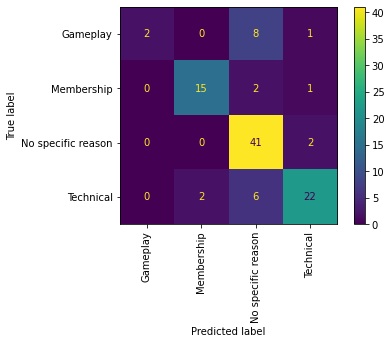

In [53]:
cm=confusion_matrix(y_test_converted,y_pred_converted)
fig=ConfusionMatrixDisplay(cm,display_labels=encoder.classes_)
fig.plot(xticks_rotation='vertical')
plt.show()

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 514,564
Trainable params: 514,564
Non-trainable params: 0
_________________________________________________________________


# Confusion Matrix for nueral network

## 4.8 Model selection

Now, it is time to comapre the performance of all models that have been trained so far and pick the one that would be used in making predictions.

In [42]:
model_selection=pd.DataFrame({"Type of Classifier":["Logistic Regression","Multinomial Naive Bayes","Random Forest","XGBoost","Neural Network"],
                             "training scores":[log_rand_search.best_score_,nb_rand_search.best_score_,rand_forest_rand_search.best_score_,xgb_rand_search.best_score_,nn_train_score],
                             "testing scores":[log_test_score,nb_test_score,rf_test_score,xgb_test_score,nn_test_score]}).round(3)

In [43]:
model_selection

,Type of Classifier,training scores,testing scores
0,Logistic Regression,0.622,0.670
1,Multinomial Naive Bayes,0.584,0.569
2,Random Forest,0.624,0.615
3,XGBoost,0.615,0.519
4,Neural Network,0.959,0.705


## 5. Business Impact 

Based on the performance of the models in the different sets, the Neural network model is used for classfying the customer reviews into different categories. This can be used to do the following:
    
    1. Automatically classify the customer issues into different segments and send pre-programmed responses
    2. Monitor what type of issue is on the rise in real time
    3. Send issues to respective teams for resolution
    4. Prioritize issues to work on based on how many customers agree to each type of issue
    5. Use this as a means to predict why customers churn

## 6. Summary 

The final model is predicting the different issues at about 78% accuracy. This is valuable in automated communication to the customer as well as sending these issues to specific teams. Once the issues are addressed, the reviews can be tracked again to keep improving the customer rating.


## 7. Future Work
The model performance can be improved by including reviews with 2 or 3 stars and then training the models as well as data from the Apple Store. 